## Import libraries and init

In [1]:
# import math
# import operator
import sys
import time
# from collections import OrderedDict
# from functools import reduce
import pickle
import json
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import math
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from skhep.visual import MplPlotter as skh_plt

# import multiprocessing
import concurrent.futures

from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode
# import xrdfs_find

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils.ObjectExtractor
%aimport utils.PlotMaker
%aimport utils.HistogramContainer
%aimport utils.HistogramCalculator
OE = utils.ObjectExtractor
PM = utils.PlotMaker
HCont = utils.HistogramContainer
HCalc = utils.HistogramCalculator

In [3]:
print(sys.version_info)
print(pd.__version__)
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 10})

numCuts = np.arange(0,6)

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
0.24.2


In [ ]:
#import uproot
#import ROOT
#import numpy as np
#import pandas as pd
#from collections import OrderedDict
#import seaborn as sns
#import math
#
#%matplotlib inline
#import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#plt.style.use('default')
#plt.rcParams['grid.linestyle'] = ':'

In [ ]:
#import sys
#sys.version
#sys.version_info

In [ ]:
#print(sys.version_info)
# num_cores = multiprocessing.cpu_count()
# print(num_cores)


#executor = concurrent.futures.ThreadPoolExecutor(48)
#
#plt.style.use('default')
#plt.rcParams['grid.linestyle'] = ':'
#plt.rcParams.update({'font.size': 10})
#
#numCuts = np.arange(0,6)
#
#branch_path = 'SREffi_gbm'
#
#labels = [ f'cut{cut}' for cut in numCuts ]
#cut_descriptions = [
#    'cut1: MET/MHT trigger fired (120 GeV)',
#    'cut2: j1 pT > 120 GeV, <= 2j w/ pT > 30 GeV',
#    'cut3: mu1 pT > 5 GeV, 0.1 < |dxy| < 700 cm',
#    'cut4: mu2 pT > 5 GeV, 0.1 < |dxy| < 700 cm',
#    r'cut5: $|\Delta\Phi$(MET, mu pair)| < 0.4',
#]

In [ ]:
#all_plot_vars = ['metpt', 'jetpt','metjetphi', 'metmuphi', 'leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
#plot_vars_metjet = all_plot_vars[0:4] #['metpt', 'jetpt', 'metjetphi', 'metmuphi']
#plot_vars_muons = all_plot_vars[4:8] #['leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
#cutflow_vars = ['cutflow_incl', 'cutflow_excl']
#all_plot_xlabels = [
#    'MET [GeV]', 'Leading jet pT [GeV]', '$\Delta\Phi$(MET, jet)', '$\Delta\Phi$(MET, di-muon)',
#    'Leading muon pT [GeV]', 'Subleading muon pT [GeV]', 'dR(muons)', 'Di-muon vertex [cm]']

In [ ]:
#histos = {}
#all_bins = {}
#for plot_var in all_plot_vars:
#    histos[plot_var] = {}
#    all_bins[plot_var] = 60
#histos['cutflow_incl'] = {}
#histos['cutflow_excl'] = {}
#histos['sumgenwgt'] = {}

## Load ntuples from analyzer

In [4]:
## new signal input
with open('config/sig.json') as sigs_json_file:
    sigs = json.load(sigs_json_file)

xrdfs = client.FileSystem("root://cmseos.fnal.gov/")

redirector = 'root://cmsxrootd.fnal.gov'
sig_base_dir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/track_quality/iDM_2018_MC'
files = {}

for sig, properties in sigs.items():
    files[sig] = []
    status, listing = xrdfs.dirlist(f'{sig_base_dir}/{properties["dir"]}', DirListFlags.STAT)
    for file in listing:
        if '.root' in file.name:
            files[sig].append(f'{redirector}/{sig_base_dir}/{properties["dir"]}/{file.name}')
num_files_total = np.sum(np.array([len(files[i]) for i in files]))
print(num_files_total)
[(i, len(files[i])) for i in files]

724


[('Mchi-60p0_dMchi-20p0_ctau-1', 229), ('Mchi-5p25_dMchi-0p5_ctau-1000', 495)]

In [17]:
%%time
genDfs = OrderedDict({})
genDfsload = OrderedDict({})
recoDfs = OrderedDict({})
recoDfsload = OrderedDict({})
MAX_FILES=None # To load all possible files
#MAX_FILES=4 # For testing


global_file_counter = 1

for sig in sigs:
    
    print(f'Processing signal {sig} ({(list(sigs.keys())).index(sig)+1}/{len(sigs)})')
    
    Mchi = sig.split('_dMchi')[0].split('Mchi-')[1]
    ctau = sig.split('ctau-')[1]
    genDfs[Mchi] = OrderedDict({})
    genDfsload[Mchi] = OrderedDict({})
    genDfsload[Mchi][ctau] =[]
    recoDfs[Mchi] = OrderedDict({})
    recoDfsload[Mchi] = OrderedDict({})
    recoDfsload[Mchi][ctau] =[]
    ### Load data
    file_counter = 1
    for file in files[sig][slice(0,MAX_FILES)]:
        
        if file_counter % 10 == 1:
            print(f'Reading file {file_counter} of {len(files[sig])},'
                  f' global {global_file_counter} of {num_files_total}'
                  f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
        file_counter += 1
        global_file_counter += 1
        
        ### Open ROOT file and get tree
        genDfsload1 = uproot.open(file)['GEN/gen']
        genDfsload[Mchi][ctau].append(genDfsload1.pandas.df(['pid','pt','eta','phi','vxy','vz']))
        recoDfsload1 = uproot.open(file)['SREffi_dsa/cutsTree']
        recoDfsload[Mchi][ctau].append(recoDfsload1.pandas.df(['fired']))

        #recoDfs[Mchi][ctau] = uproot.open(file)['SREffi_dsa/cutsTree']
        
        ### Make pandas dataframes and create all objects that will be passed to histo functions
        #obj_extractor = OE.ObjectExtractor(tree)
        #objects = obj_extractor.get_all()
    genDfs[Mchi][ctau]= pd.concat(genDfsload[Mchi][ctau])
    recoDfs[Mchi][ctau]= pd.concat(recoDfsload[Mchi][ctau])
print(recoDfs['60p0']['1'])

Processing signal Mchi-60p0_dMchi-20p0_ctau-1 (1/2)
Reading file 1 of 229, global 1 of 724 (0.00%)
Reading file 11 of 229, global 11 of 724 (1.38%)
Reading file 21 of 229, global 21 of 724 (2.76%)
Reading file 31 of 229, global 31 of 724 (4.14%)
Reading file 41 of 229, global 41 of 724 (5.52%)
Reading file 51 of 229, global 51 of 724 (6.91%)
Reading file 61 of 229, global 61 of 724 (8.29%)
Reading file 71 of 229, global 71 of 724 (9.67%)
Reading file 81 of 229, global 81 of 724 (11.05%)
Reading file 91 of 229, global 91 of 724 (12.43%)
Reading file 101 of 229, global 101 of 724 (13.81%)
Reading file 111 of 229, global 111 of 724 (15.19%)
Reading file 121 of 229, global 121 of 724 (16.57%)
Reading file 131 of 229, global 131 of 724 (17.96%)
Reading file 141 of 229, global 141 of 724 (19.34%)
Reading file 151 of 229, global 151 of 724 (20.72%)
Reading file 161 of 229, global 161 of 724 (22.10%)
Reading file 171 of 229, global 171 of 724 (23.48%)
Reading file 181 of 229, global 181 of 724

In [31]:
recoDfs['60p0']['1'].join(genDfs['60p0']['1'])

NotImplementedError: Index._join_level on non-unique index is not implemented

In [10]:
#%%time
#genDfs = OrderedDict({})
#recoDfs = OrderedDict({})
#MAX_FILES=None # To load all possible files
# MAX_FILES=1 # For testing
#
#
#global_file_counter = 1
#
#for sig in sigs:
#    
#    print(f'Processing signal {sig} ({(list(sigs.keys())).index(sig)+1}/{len(sigs)})')
#    
#    Mchi = sig.split('_dMchi')[0].split('Mchi-')[1]
#    ctau = sig.split('ctau-')[1]
#    genDfs[Mchi] = OrderedDict({})
#    recoDfs[Mchi] = OrderedDict({})
#    ### Load data
#    file_counter = 1
#    for file in files[sig][slice(0,MAX_FILES)]:
#        
#        if file_counter % 10 == 1:
#            print(f'Reading file {file_counter} of {len(files[sig])},'
#                  f' global {global_file_counter} of {num_files_total}'
#                  f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
#        file_counter += 1
#        global_file_counter += 1
#        
#        ### Open ROOT file and get tree
#        genDfs[Mchi][ctau] = uproot.open(file)['GEN/gen']
#        recoDfs[Mchi][ctau] = uproot.open(file)['SREffi_dsa/cutsTree']
#        
#        ### Make pandas dataframes and create all objects that will be passed to histo functions
#        #obj_extractor = OE.ObjectExtractor(tree)
#        #objects = obj_extractor.get_all()
#

In [ ]:
#masses = [('60','20'),('52p5','5p0'),('6p0','2p0'),('5p25','0p5')]
#mchis = ['60', '52p5', '6p0', '5p25']
#ctaus = [1, 10, 100, 1000]

#branchFolder = 'RECO_dsa'
# baseDir = '../Firefighter/washAOD/trigger2018Studies/'
#baseDir = '../Firefighter/washAOD/trigger2017Studies/'
#fileName = lambda Mchi, dMchi, ctau: baseDir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

#numParams = len(masses)*len(ctaus)
#count = 1

#recoDfs = OrderedDict({})
#genDfs = OrderedDict({})
#for (Mchi, dMchi) in masses:
#    recoDfs[Mchi] = OrderedDict({})
#    genDfs[Mchi] = OrderedDict({})
#    for ctau in ctaus:
#         recoDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['RECO_dsa' + '/recoEffiForMuTrack'].pandas.df()
#        recoDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['TRIGself_dsa_HLT_PFMET120_PFMHT120' + '/trigSelfEffiForMuTrack'].pandas.df()
#        genDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['GEN' + '/gen'].pandas.df()
#        print(f'{count} of {numParams}: ' + fileName(Mchi, dMchi, ctau))
#        count += 1

## Muon pT plots

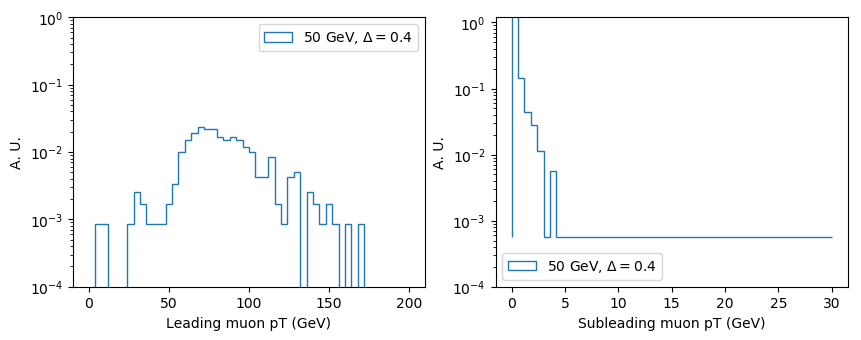

In [62]:
labels = {'60p0':'50 GeV, $\Delta=0.4$', '52p5':'50 GeV, $\Delta=0.1$', \
         '6p0':'5   GeV, $\Delta=0.4$', '5p25':'5   GeV, $\Delta=0.1$'}
mchis = ['60p0']#, '52p5', '6p0', '5p25']
ctaus = ['1']#, 10, 100, 1000]
#ctau = '1'
fig, ax = plt.subplots(1,2, figsize=(10,3.5))
genNewDfs = OrderedDict({})
recoNewDfs = OrderedDict({})
leadingMuPt = OrderedDict({})
subleadingMuPt = OrderedDict({})
for mchi in mchis:
    genNewDfs[mchi] = OrderedDict({})
    recoNewDfs[mchi] = OrderedDict({})
    leadingMuPt[mchi] = OrderedDict({})
    for ctau in ctaus:
        #genNewDfs[mchi][ctau] = genDfs[mchi][ctau].pandas.df(['pid','pt','eta','phi'])
        #leadingMuPt[mchi][ctau] = genNewDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].max()
        leadingMuPt[mchi][ctau] = genDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].max()
    #print(genNewDfs[mchi][ctau])
        ax[0].hist(leadingMuPt[mchi][ctau], bins=50, range=(0,200), histtype='step', density=True, log=True, label=labels[mchi]);
ax[0].set_ylim([0.0001, 1])
ax[0].set_xlabel('Leading muon pT (GeV)')
ax[0].set_ylabel('A. U.')
ax[0].legend();

for mchi in mchis:
    subleadingMuPt[mchi] = OrderedDict({})
    for ctau in ctaus:
        subleadingMuPt[mchi][ctau] = genDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].min()
        ax[1].hist(subleadingMuPt[mchi][ctau], bins=50, range=(0,30), histtype='step', density=True, log=True, label=labels[mchi]);
ax[1].set_ylim([0.0001, 1.2])
ax[1].set_xlabel('Subleading muon pT (GeV)')
ax[1].set_ylabel('A. U.')
ax[1].legend();


## Muon phi and dR plots

In [12]:
# Helper function to normalize angle differences to [-Pi, Pi]
# cond: if abs(phidiff) > Pi => phidiff = phidiff - 2*Pi*sign(phidiff)
def reducephi(row):
    if abs(row) > math.pi:
        return row - 2*math.pi*(row/abs(row))
    return row

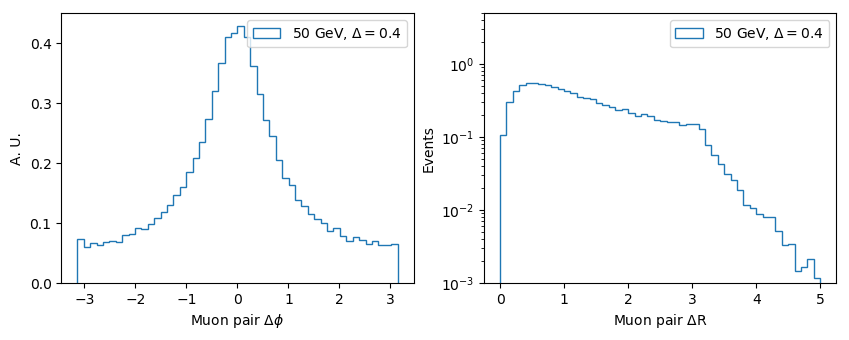

In [13]:
# plt.figure(figsize=(5,3.5))
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

for mchi in mchis:
    #reducedGenDf_mu = genNewDfs[mchi][ctau].query('pid==13|pid==-13')[['eta','phi']]#.unstack(level=1)
    reducedGenDf_mu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==13].reset_index(level=1)#[['eta','phi']]
    reducedGenDf_antimu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==-13].reset_index(level=1)#[['eta','phi']]
    #reducedGenDf_antimu = genNewDfs[mchi][ctau].query('pid==-13')[['eta','phi']].unstack(level=1)
    #print('mu:',reducedGenDf_mu)
    #print('anti',reducedGenDf_antimu['phi'] )
    #reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    #phidiff = reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2']
    phidiff = reducedGenDf_mu['phi'].sub(reducedGenDf_antimu['phi'])
    #print(phidiff)
#     phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
#         abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
    reducedphidiff = phidiff.apply(reducephi)
    ax[0].hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi], log=False);

ax[0].set_xlabel('Muon pair $\Delta\phi$')
ax[0].set_ylabel('A. U.')
ax[0].legend();

for mchi in mchis:
    reducedGenDf_mu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==13].reset_index(level=1)#[['eta','phi']]
    reducedGenDf_antimu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==-13].reset_index(level=1)#[['eta','phi']]
    phidiff = pd.concat([abs((math.pi - abs(reducedGenDf_mu['phi'])) + (math.pi - abs(reducedGenDf_antimu['phi']))), \
        abs(reducedGenDf_mu['phi'] - reducedGenDf_antimu['phi'])], axis=1).min(axis=1)
    deltaR = np.sqrt((reducedGenDf_mu['eta'] - reducedGenDf_antimu['eta'])**2 + (phidiff)**2)
    #reducedGenDf = genNewDfs[mchi][ctau].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    #reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    #phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
    #    abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
    #deltaR = np.sqrt((reducedGenDf['eta']['mu1'] - reducedGenDf['eta']['mu2'])**2 + (phidiff)**2)
    ax[1].hist(deltaR, bins=50, range=(0,5), density=True, log=True, histtype='step', label=labels[mchi]);

ax[1].set_xlabel('Muon pair $\Delta$R')
ax[1].set_ylabel('Events')
ax[1].set_ylim(0.001, 5)
ax[1].legend();

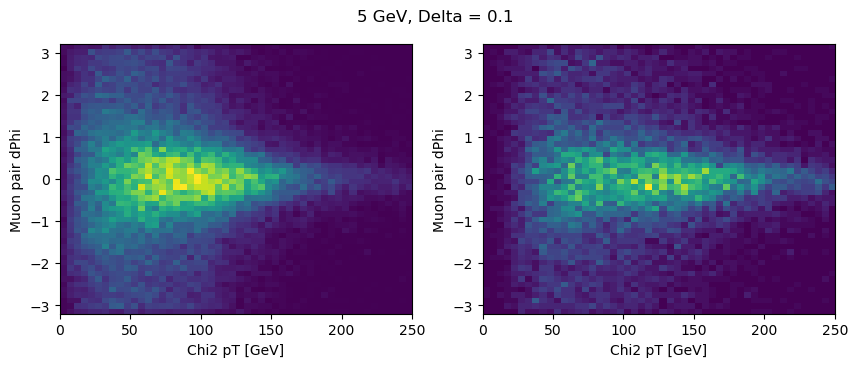

In [52]:
mchi = '60p0'
ctau = '1'
fig, axes = plt.subplots(1,2, figsize=(10,3.5))
recoNewDfs[mchi][ctau] = recoDfs[mchi][ctau]['fired']
#print(recoNewDfs[mchi][ctau2])
chi2pTs =  pd.DataFrame.from_dict(genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==1000023 ]['pt'])#.#reset_index(level=1)
chi2pTs['fired'] = recoDfs[mchi][ctau]['fired'].tolist()
#print(chi2pTs)


reducedGenDf_mu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==13].reset_index(level=1)#[['eta','phi']]
reducedGenDf_antimu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==-13].reset_index(level=1)#[['eta','phi']]
phidiff = reducedGenDf_mu['phi'].sub(reducedGenDf_antimu['phi'])
reducedphidiff = phidiff.apply(reducephi)

#print(pd.DataFrame.from_dict(reducedphidiff))
chi2pTs['phi'] = reducedphidiff.tolist()


axes[0].hist2d(chi2pTs.dropna()['pt'], chi2pTs.dropna()['phi'], bins=(50,50), range=((0,250),(-3.2,3.2)));
axes[0].set_xlabel('Chi2 pT [GeV]')
axes[0].set_ylabel('Muon pair dPhi');

axes[1].hist2d(chi2pTs[chi2pTs['fired']==1].dropna()['pt'], chi2pTs[chi2pTs['fired']==1].dropna()['phi'], bins=(50,50), range=((0,250),(-3.2,3.2)));
axes[1].set_xlabel('Chi2 pT [GeV]')
axes[1].set_ylabel('Muon pair dPhi');
fig.suptitle('5 GeV, Delta = 0.1');


#plt.hist(reducedphidiff,bins=50,histtype='step',density=True, label='All')
#plt.xlabel('Muon pair dPhi')
#plt.ylabel('A. U.')
#plt.hist(chi2pTs.dropna()['phi'],bins=50,histtype='step',density=True,label='Triggered');
#plt.legend();
#plt.title('5 GeV, Delta = 0.1');

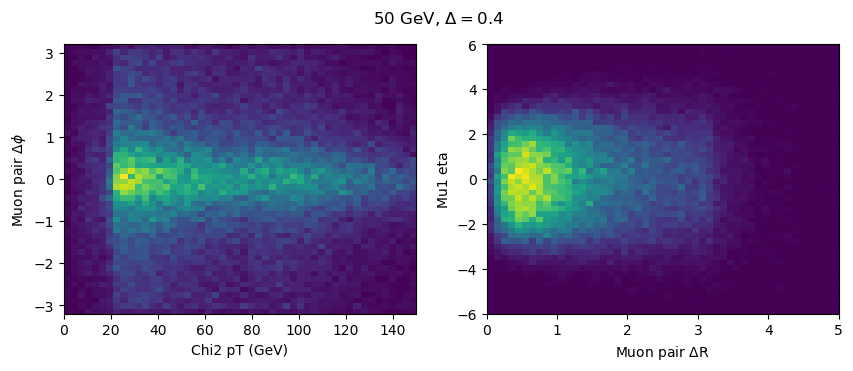

In [65]:
for mchi in mchis:
    fig, ax = plt.subplots(1,2, figsize=(10,3.5))
    fig.suptitle(' '.join(labels[mchi].split()))
    reducedGenDf_mu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==13].reset_index(level=1)#[['eta','phi']]
    reducedGenDf_antimu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==-13].reset_index(level=1)#[['eta','phi']]
    phidiff = reducedGenDf_mu['phi'].sub(reducedGenDf_antimu['phi'])
    reducedphidiff = phidiff.apply(reducephi)
    #reducedGenDf = genDfs[mchi][ctau].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    #reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    #phidiff = reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2']
    #     phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
    #         abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
    #reducedphidiff = phidiff.apply(reducephi)
    
    ax[0].hist2d(genDfs[mchi][ctau].loc[(slice(None), 2), :]['pt'], reducedphidiff, bins=(50,50), range=((0,150),(-3.2,3.2)));
    ax[0].set_ylabel('Muon pair $\Delta\phi$')
    ax[0].set_xlabel('Chi2 pT (GeV)')

    #reducedGenDf = genDfs[mchi][ctau].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    #reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    phidiff = pd.concat([abs((math.pi - abs(reducedGenDf_mu['phi'])) + (math.pi - abs(reducedGenDf_antimu['phi']))), \
        abs(reducedGenDf_mu['phi'] - reducedGenDf_antimu['phi'])], axis=1).min(axis=1)
    deltaR = np.sqrt((reducedGenDf_mu['eta'] - reducedGenDf_antimu['eta'])**2 + (phidiff)**2)
    
    ax[1].hist2d(deltaR, reducedGenDf_mu['eta'], label=labels[mchi], alpha=1.0, bins=(50,50), range=((0,5),(-6,6)))    
    ax[1].set_xlabel('Muon pair $\Delta$R')
    ax[1].set_ylabel('Mu1 eta')

## Muon eta distributions

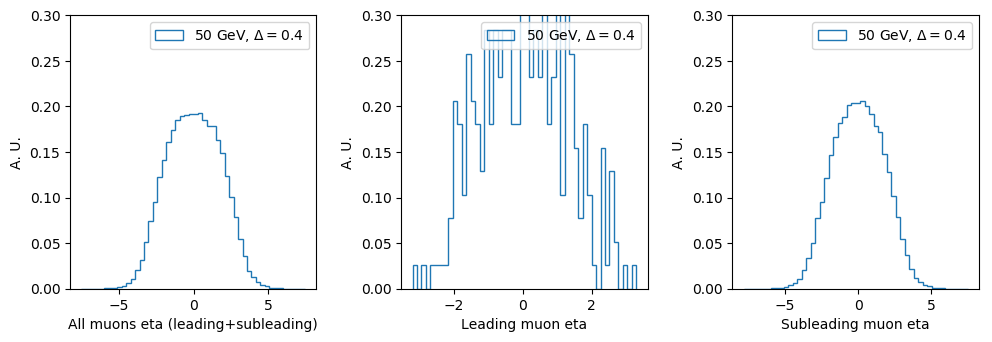

In [55]:
fig, ax = plt.subplots(1,3, figsize=(10,3.5))

for mchi in mchis:
    ax[0].hist(genDfs[mchi][ctau].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label=labels[mchi], histtype='step');

ax[0].set_xlabel('All muons eta (leading+subleading)')
ax[0].set_ylabel('A. U.')
ax[0].set_ylim(0, 0.3)
ax[0].legend();

for mchi in mchis:
    idx = genDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genDfs[mchi][ctau].query('pid==13|pid==-13')['pt']
    leadingMu = genDfs[mchi][ctau].query('pid==13|pid==-13').loc[idx]
    subleadingMu = genDfs[mchi][ctau].query('pid==13|pid==-13').loc[~idx]
    ax[1].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label=labels[mchi])
    ax[2].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label=labels[mchi])


ax[1].set_xlabel('Leading muon eta')
ax[1].set_ylabel('A. U.')
ax[1].set_ylim(0, 0.3)
ax[1].legend();

ax[2].set_xlabel('Subleading muon eta')
ax[2].set_ylabel('A. U.')
ax[2].set_ylim(0, 0.3)
ax[2].legend();

plt.tight_layout(pad=1.0)

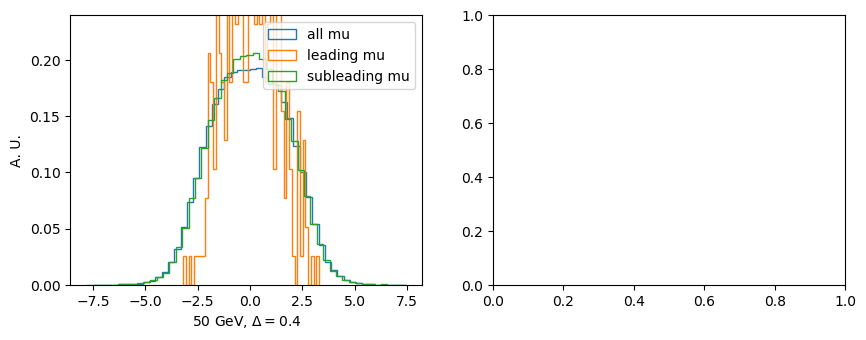

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

mchi = '60p0'

ax[0].hist(genDfs[mchi][ctau].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label='all mu', histtype='step');
idx = genDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genDfs[mchi][ctau].query('pid==13|pid==-13')['pt']
leadingMu = genDfs[mchi][ctau].query('pid==13|pid==-13').loc[idx]
subleadingMu = genDfs[mchi][ctau].query('pid==13|pid==-13').loc[~idx]
ax[0].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label='leading mu');
ax[0].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label='subleading mu');

ax[0].set_xlabel(labels[mchi])
ax[0].set_ylabel('A. U.')
ax[0].set_ylim(0, 0.24)
ax[0].legend();

#mchi = '5p25'
#ctau2 = 1000
#ax[1].hist(genNewDfs[mchi][ctau2].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label='all mu', histtype='step');
#idx = genNewDfs[mchi][ctau2].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genNewDfs[mchi][ctau2].query('pid==13|pid==-13')['pt']
#leadingMu = genNewDfs[mchi][ctau2].query('pid==13|pid==-13').loc[idx]
#subleadingMu = genNewDfs[mchi][ctau2].query('pid==13|pid==-13').loc[~idx]
#ax[1].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label='leading mu');
#ax[1].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label='subleading mu');

#ax[1].set_xlabel(labels[mchi])
#ax[1].set_ylabel('A. U.')
#ax[1].set_ylim(0, 0.24)
#ax[1].legend();

## Muons eta vs pT

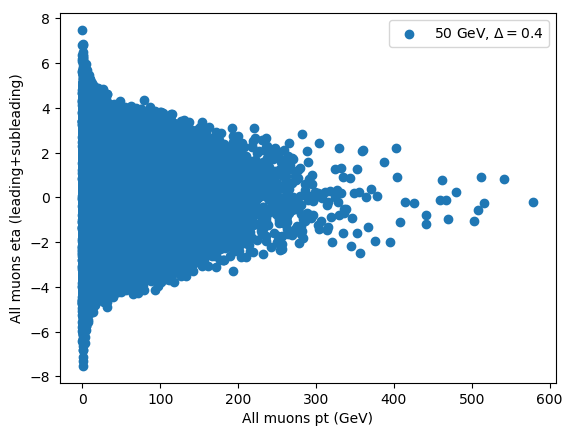

In [58]:
for mchi in mchis:
#     plt.hist(genNewDfs[mchi][10].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label=labels[mchi], histtype='step');
    plt.scatter(genDfs[mchi][ctau].loc[(slice(None), [5,6]), :]['pt'], genDfs[mchi][ctau].loc[(slice(None), [5,6]), :]['eta'], label=labels[mchi])
    plt.ylabel('All muons eta (leading+subleading)')
    plt.xlabel('All muons pt (GeV)')
plt.legend();

## Muon vxy and vz plots

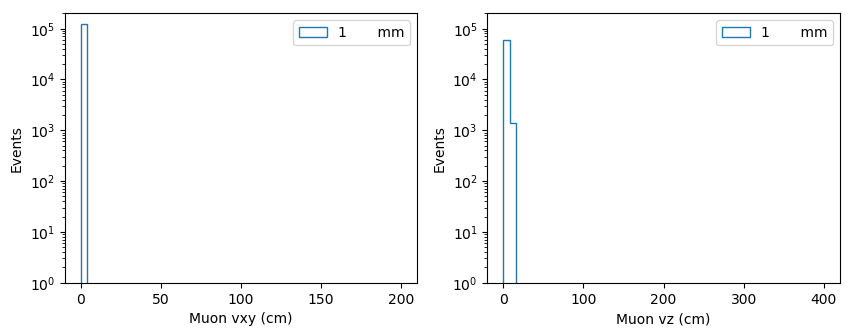

In [60]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

labels_ctau = {'1':'1       mm', 10:'10     mm', 100:'100   mm', 1000:'1000 mm'}
# labels_ctau = {1:'1 mm', 10:'10 mm', 100:'100 mm', 1000:'1000 mm'}
genDfs_v = OrderedDict({})
genDfs_v[mchi] = OrderedDict({})
for ctau in ctaus:
    #vxy = genDfs['60p0'][ctau].query('(pid==13|pid==-13)&subentry==5')['vxy']
    genDfs_v[mchi][ctau] = genDfs[mchi][ctau]
    vxy = genDfs_v[mchi][ctau][(genDfs_v[mchi][ctau]['pid']==13) | (genDfs_v[mchi][ctau]['pid']==-13)]['vxy']
    ax[0].hist(vxy, bins=50, range=(0,200), histtype='step', density=False, log=True, label=labels_ctau[ctau]);
ax[0].set_ylim([1, 200000])
ax[0].set_xlabel('Muon vxy (cm)')
ax[0].set_ylabel('Events')
ax[0].legend();

for ctau in ctaus:
    #vz = genDfs['60p0'][ctau].query('(pid==13|pid==-13)&subentry==5')['vz']
    vz = genDfs_v['60p0'][ctau][(genDfs_v['60p0'][ctau]['pid']==13) | (genDfs_v['60p0'][ctau]['pid']==-13)]['vz']
    ax[1].hist(vz, bins=50, range=(0,400), histtype='step', density=False, log=True, label=labels_ctau[ctau]);
ax[1].set_ylim([1, 200000])
ax[1].set_xlabel('Muon vz (cm)')
ax[1].set_ylabel('Events')
ax[1].legend();

## Load files with additional data (jet eta and phi, MET phi) to make relevant plots

In [ ]:
masses = [('60','20'),('52p5','5p0'),('6p0','2p0'),('5p25','0p5')]
mchis = ['60', '52p5', '6p0', '5p25']
ctaus = [10]

branchFolder = 'RECO_dsa'
baseDir = '../Firefighter/washAOD/GenInfoStudies/'
fileName = lambda Mchi, dMchi, ctau: baseDir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

numParams = len(masses)*len(ctaus)
count = 1

recoNewDfs = OrderedDict({})
genNewDfs = OrderedDict({})
for (Mchi, dMchi) in masses:
    recoNewDfs[Mchi] = OrderedDict({})
    genNewDfs[Mchi] = OrderedDict({})
    for ctau in ctaus:
        recoNewDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['RECO_dsa' + '/recoEffiForMuTrack'].pandas.df()
        genNewDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['GEN' + '/gen'].pandas.df()
        print(f'{count} of {numParams}: ' + fileName(Mchi, dMchi, ctau))
        count += 1

## Plot deltaPhi between jet and MET

In [ ]:
plt.figure(figsize=(5,3.5))

for mchi in mchis:
    reducedGenDf = genNewDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    phidiff = recoNewDfs[mchi][10]['genJetPhi'].dropna() - recoNewDfs[mchi][10]['genLeadMetPhi'].dropna()
    reducedphidiff = phidiff.apply(reducephi)
#     phidiff = pd.concat([abs((math.pi - abs(recoNewDfs[mchi][10]['genJetPhi'].dropna())) + (math.pi - abs(recoNewDfs[mchi][10]['genLeadMetPhi'].dropna()))), \
#         abs(recoNewDfs[mchi][10]['genJetPhi'].dropna() - recoNewDfs[mchi][10]['genLeadMetPhi'].dropna())], axis=1).min(axis=1)
    plt.hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi]);

plt.xlabel('$\Delta\phi$ (jet, MET)')
plt.ylabel('A. U.')
plt.legend(loc='upper center');

## Plot deltaPhi between MET and muon pair and between the 2 chi1 DM particles

In [ ]:
mchi='5p25'

crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
eventsWith2Mus = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) ]
phi1 = eventsWith2Mus.query('subentry==0')['phi'].reset_index()['phi']
phi2 = eventsWith2Mus.query('subentry==1')['phi'].reset_index()['phi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))

phichi1_1 = genDfs[mchi][10].query('subentry==3').reset_index()['phi']
phichi1_2 = genDfs[mchi][10].query('subentry==4').reset_index()['phi']
avgchi1Phi = pd.DataFrame(np.arctan2((np.sin(phichi1_1) + np.sin(phichi1_2)), (np.cos(phichi1_1) + np.cos(phichi1_2))))
finalchiavgphi=avgchi1Phi.reset_index().loc[ avgchi1Phi.reset_index()['index'].isin(eventsWith2Mus.query('subentry==1')['entry']) ].reset_index()['phi']
phidiff = avgPhi['phi'] - finalchiavgphi
reducedphi = phidiff.apply(reducephi)
plt.hist(reducedphi,bins=50,histtype='step', density=True, label='All');



trigEvents = recoDfs[mchi][10].query('subentry==0&fired==True').reset_index()['entry']

crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
eventsWith2MusAndTrig = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) \
                                                           & recoDfs[mchi][10].reset_index()['entry'].isin(trigEvents) ]
phi1 = eventsWith2MusAndTrig.query('subentry==0')['phi'].reset_index()['phi']
phi2 = eventsWith2MusAndTrig.query('subentry==1')['phi'].reset_index()['phi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))

phichi1_1 = genDfs[mchi][10].query('subentry==3').reset_index()['phi']
phichi1_2 = genDfs[mchi][10].query('subentry==4').reset_index()['phi']
avgchi1Phi = pd.DataFrame(np.arctan2((np.sin(phichi1_1) + np.sin(phichi1_2)), (np.cos(phichi1_1) + np.cos(phichi1_2))))
finalchiavgphi=avgchi1Phi.reset_index().loc[ avgchi1Phi.reset_index()['index'].isin(eventsWith2MusAndTrig.query('subentry==1')['entry']) ].reset_index()['phi']
phidiff = avgPhi['phi'] - finalchiavgphi
reducedphi = phidiff.apply(reducephi)
plt.hist(reducedphi,bins=50,histtype='step', density=True, label='Triggered');

plt.xlabel('dPhi between muon pair (avg. phi) and chi1 pair (avg. phi)')
plt.ylabel('A. U.')
plt.title('5 GeV, Delta = 0.1')
plt.legend();

In [ ]:
crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
eventsWith2Mus = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) ]
phi1 = eventsWith2Mus.query('subentry==0')['phi'].reset_index()['phi']
phi2 = eventsWith2Mus.query('subentry==1')['phi'].reset_index()['phi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
# reducedDf = pd.concat([avgPhi, eventsWith2Mus.query('subentry==0')['genLeadMetPhi']], axis=1)
# phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']
# reducedphidiff = phidiff.apply(reducephi)

In [ ]:
phi1 = recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genPhi']
phi2 = recoNewDfs[mchi][10].query('subentry==1').reset_index('subentry')['genPhi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
reducedDf = pd.concat([avgPhi, recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genLeadMetPhi']], axis=1)
phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']
reducedphidiff = phidiff.apply(reducephi)

In [ ]:
# plt.figure(figsize=(5,3.5))
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

for mchi in mchis:
    phidiff = genNewDfs[mchi][10].query('subentry==3').reset_index('subentry')['phi'] - \
                genNewDfs[mchi][10].query('subentry==4').reset_index('subentry')['phi']
    reducedphidiff = phidiff.apply(reducephi)
    ax[0].hist(reducedphidiff, bins=50, density=True, histtype='step', label=labels[mchi])

ax[0].set_xlabel('$\Delta\phi$ (light DM 1, light DM 2)')
ax[0].set_ylabel('A. U.')
ax[0].legend(prop={'size': 9});

for mchi in mchis:
    phi1 = recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genPhi']
    phi2 = recoNewDfs[mchi][10].query('subentry==1').reset_index('subentry')['genPhi']
    avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
    reducedDf = pd.concat([avgPhi, recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genLeadMetPhi']], axis=1)
    phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']
    reducedphidiff = phidiff.apply(reducephi)
    ax[1].hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi], log=False);

ax[1].set_xlabel('$\Delta\phi$ (MET, muon pair)')
ax[1].set_ylabel('A. U.')
ax[1].legend(prop={'size': 9});

# phidiff = pd.concat([abs(2*math.pi - abs(genNewDfs['60'][10].query('subentry==3').reset_index('subentry')['phi']) - abs(genNewDfs['60'][10].query('subentry==4').reset_index('subentry')['phi'])), \
#         abs(genNewDfs['60'][10].query('subentry==3').reset_index('subentry')['phi'] - genNewDfs['60'][10].query('subentry==4').reset_index('subentry')['phi'])], axis=1).min(axis=1)

## Di-muon invariant mass plot

In [ ]:
# M_A'^2 = (e1 + e2)^2 - (px1+px2)^2 + (py1+py2)^2 + (pz1+pz2)^2
# Or M_A'^2 = 2 * pT1 * pT2 * (cosh(eta1 - eta2) - cos(phi1 - phi2))

for mchi in mchis:
    reducedDf = genNewDfs[mchi][10].query('subentry==5|subentry==6')[['pt','eta','phi']]
    idx = pd.IndexSlice

    invMass = np.sqrt(2 * reducedDf.loc[idx[:,5], 'pt'].reset_index(level=1).drop(columns='subentry')['pt'] * \
    reducedDf.loc[idx[:,6], 'pt'].reset_index(level=1).drop(columns='subentry')['pt'] * \
    (np.cosh(reducedDf.loc[idx[:,5], 'eta'].reset_index(level=1).drop(columns='subentry')['eta'] - \
            reducedDf.loc[idx[:,6], 'eta'].reset_index(level=1).drop(columns='subentry')['eta']) - \
    np.cos(reducedDf.loc[idx[:,5], 'phi'].reset_index(level=1).drop(columns='subentry')['phi'] - \
            reducedDf.loc[idx[:,6], 'phi'].reset_index(level=1).drop(columns='subentry')['phi'])))

    plt.hist(invMass, bins=50, density=True, histtype='step', log=True, label=labels[mchi]);

plt.ylim([0.001, 10])
plt.xlabel('Di-muon invariant mass (GeV)')
plt.ylabel('A. U.')
plt.legend(loc='upper right');

## Test stuff

In [ ]:
test=pd.concat([abs(2*math.pi - abs(reducedGenDf['phi']['mu1']) - abs(reducedGenDf['phi','mu2'])), \
        abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1)
test2=pd.concat([test, reducedGenDf], axis=1)
# test2[('phi','mu2')]
# test2['avg'] = test2[ test2[0] > test2[1] ][('phi','mu1')]/2 + test2[ test2[0] > test2[1] ][('phi','mu2')]/2
# test2['avg2'] = test2[ (test2[0] < test2[1]) & (test2[('phi','mu1')]>test2[('phi','mu2')]) ][('phi','mu1')] + \
#                 test2[ (test2[0] < test2[1]) & (test2[('phi','mu1')]>test2[('phi','mu2')]) ][0]/2
# test2['avg2'] = test2[ (test2[0] < test2[1]) & (test2[('phi','mu1')]<test2[('phi','mu2')]) ][('phi','mu2')] + \
#                 test2[ (test2[0] < test2[1]) & (test2[('phi','mu1')]<test2[('phi','mu2')]) ][0]/2
# test2['avg3'] = test2[ (test2[0] < test2[1]) & (test2['avg2']>math.pi) ]['avg2'] - 2*math.pi
test2['avg0'] = test2[('phi','mu1')]/2 + test2[('phi','mu2')]/2
test2['avg1'] = test2[('phi','mu1')] + test2[0]/2
test2['avg1.5'] = test2[('phi','mu2')] + test2[0]/2

def f(row):
    if row[0] > row[1]:
        return row['avg0']
    if row[('phi','mu1')] > row[('phi','mu2')]:
        if row['avg1'] > math.pi:
            return row['avg1'] - 2*math.pi
        return row['avg1']
    if row['avg1.5'] > math.pi:
        return row['avg1.5'] - 2*math.pi
    return row['avg1.5']

test2['final'] = test2.apply(f, axis=1)